In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install --upgrade transformers==4.25.1

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install -q --upgrade transformers diffusers ftfy

In [ ]:
!pip install transformers
!pip install accelerate

In [3]:
from base64 import b64decode

import numpy
import torch
import accelerate

from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging

torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [4]:
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder = 'vae')

In [5]:
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

In [6]:
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

In [7]:
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

## Diffusion loopprompt = ["A colorful dancer, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

In [8]:
prompt = ["A watercolor painting of an platypus riding a horse"]
height = 448                         # default height of Stable Diffusion
width = 448                         # default width of Stable Diffusion
num_inference_steps = 30            # Number of denoising steps
guidance_scale = 7.5                # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

## Preparing the text
text_input = tokenizer(prompt, padding='max_length', max_length=tokenizer.model_max_length,truncation=True, 
                       return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding = "max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings,text_embeddings])

#Preparing the Scheduler
scheduler.set_timesteps(num_inference_steps)

#Prep latents
latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width//8),
    generator = generator,
)
letents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

with autocast('cuda'):
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        latent_model_input = torch.cat([latents] *2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)
        latent_model_input = latent_model_input.to(torch_device)
        # to preduct residual noise
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states = text_embeddings).sample
        
        #perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        noise_pred=noise_pred.to(torch_device)
        latents = scheduler.step(noise_pred,t.to(torch_device),latents.to(torch_device)).prev_sample

0it [00:00, ?it/s]

In [9]:
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

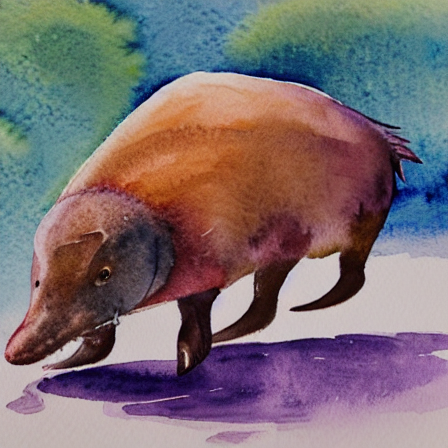

In [10]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 250).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [11]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

In [12]:
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

curl: /opt/conda/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 62145  100 62145    0     0   247k      0 --:--:-- --:--:-- --:--:--  247k


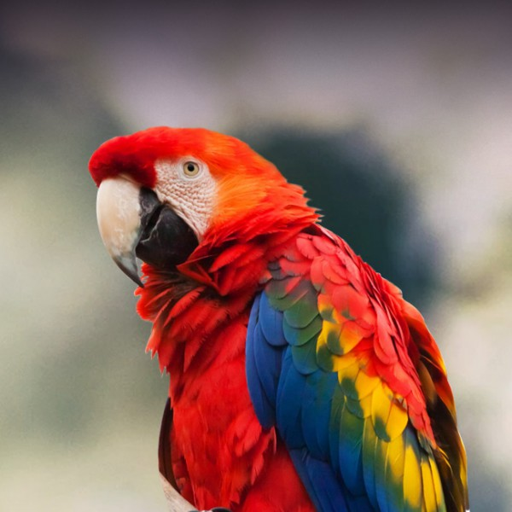

In [13]:
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

In [14]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

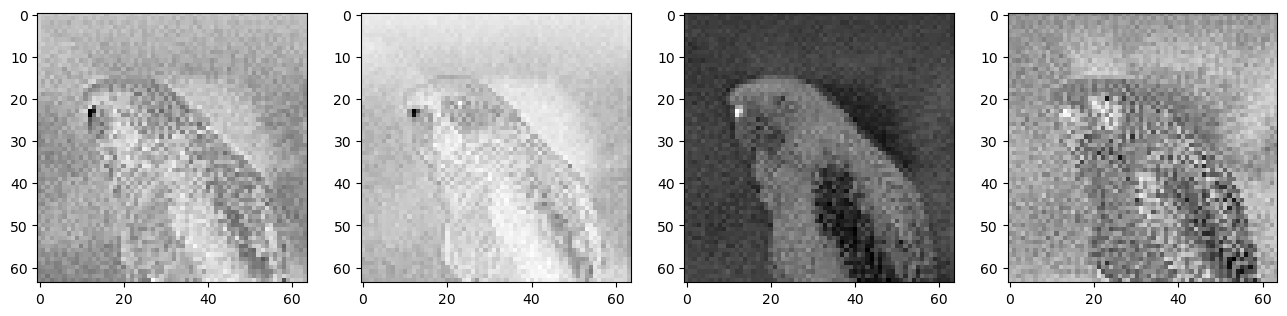

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

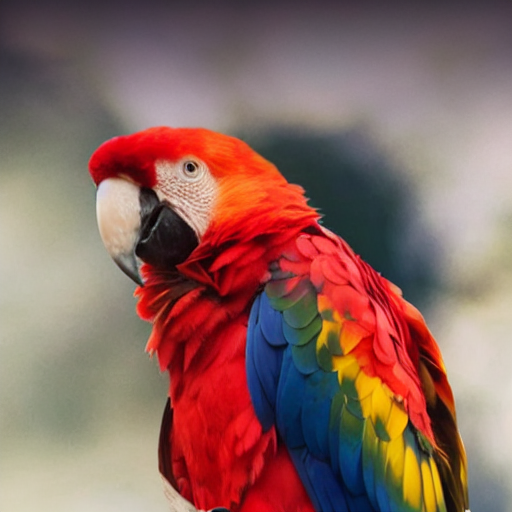

In [16]:
decoded = latents_to_pil(encoded)[0]
decoded

In [17]:
scheduler.set_timesteps(15)

In [18]:
print(scheduler.timesteps)

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000], dtype=torch.float64)


In [19]:
print(scheduler.sigmas)

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])


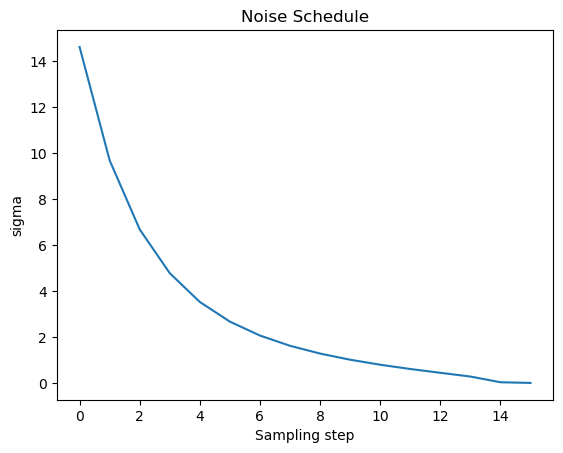

In [20]:
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')
plt.ylabel('sigma')
plt.show()

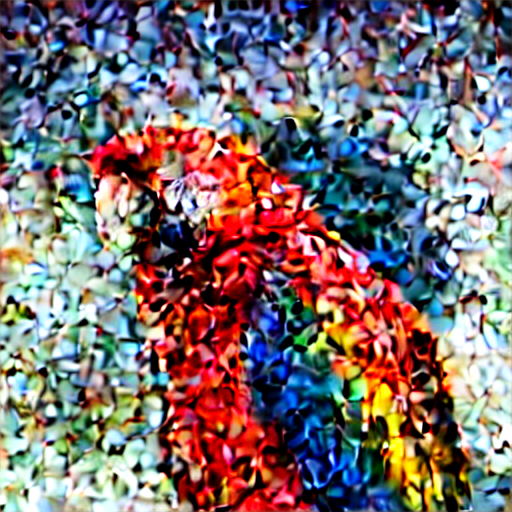

In [21]:
noise = torch.randn_like(encoded) # Random noise
sampling_step = 9 # Equivalent to step 10 out of 15 in the schedule above
# encoded_and_noised = scheduler.add_noise(encoded, noise, timestep) # Diffusers 0.3 and below
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latents_to_pil(encoded_and_noised.float())[0] # Display

In [22]:
prompt = ["Soccer player, nat geo photo"]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

0it [00:00, ?it/s]

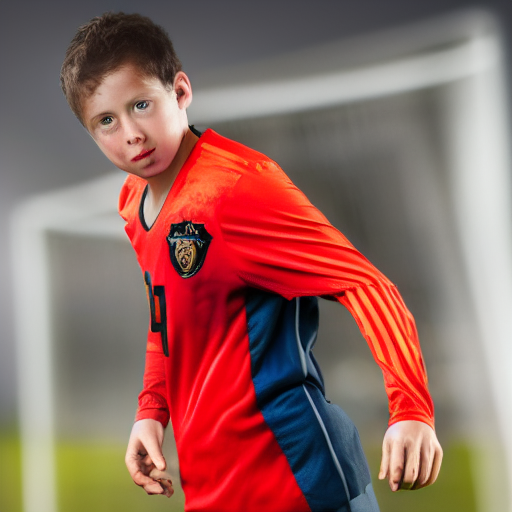

In [23]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

scheduler.set_timesteps(num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = 10
start_sigma = scheduler.sigmas[start_step]
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

for i, t in tqdm(enumerate(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do
        
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latents_to_pil(latents)[0]

In [39]:
prompt = 'A picture of a whale'

In [40]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] # View the tokens

tensor([49406,   320,  1674,   539,   320, 11650, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [41]:
for t in text_input['input_ids'][0][:8]: # We'll just look at the first 7 to save you from a wall of '<|endoftext|>'
    print(t, tokenizer.decoder.get(int(t)))

tensor(49406) <|startoftext|>
tensor(320) a</w>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(11650) whale</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [42]:
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print('Shape:', output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.9502, -0.3793, -1.3005,  ..., -0.7673, -1.1718,  0.0160],
         [-0.9472, -0.3771, -1.3017,  ..., -0.7596, -1.1680,  0.0189],
         [-0.9597, -0.3170, -1.2410,  ..., -0.7650, -1.1314, -0.0167]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [43]:
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer # Vocab size 49408, emb_dim 768

Embedding(49408, 768)

In [44]:
embedding = token_emb_layer(torch.tensor(11650, device=torch_device))
embedding.shape

torch.Size([768])

In [45]:
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape) # batch size 1, 77 tokens, 768 values for each
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0013, -0.0011, -0.0126,  ..., -0.0124,  0.0120,  0.0080],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [46]:
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [47]:
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [48]:
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
input_embeddings

torch.Size([1, 77, 768])


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [49]:
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 5.5371e-03,  1.7510e-03, -1.2381e-02,  ..., -1.1410e-02,
           1.3508e-02,  6.8378e-03],
         [ 2.5356e-02, -1.1019e-02,  9.7663e-03,  ...,  1.9460e-03,
           6.8375e-03,  1.8573e-02],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [50]:
def get_output_embeds(input_embeddings):
    # CLIP's text model uses causal mask, so we prepare it here:
    bsz, seq_len = input_embeddings.shape[:2]
    causal_attention_mask = text_encoder.text_model._build_causal_attention_mask(bsz, seq_len, dtype=input_embeddings.dtype)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True 
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # We're interested in the output hidden state only
    output = encoder_outputs[0]

    # There is a final layer norm we need to pass these through
    output = text_encoder.text_model.final_layer_norm(output)

    # And now they're ready!
    return output

out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
print(out_embs_test.shape) # Check the output shape
out_embs_test # Inspect the output

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.9502, -0.3793, -1.3005,  ..., -0.7673, -1.1718,  0.0160],
         [-0.9472, -0.3771, -1.3017,  ..., -0.7596, -1.1680,  0.0189],
         [-0.9597, -0.3170, -1.2410,  ..., -0.7650, -1.1314, -0.0167]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [36]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. In this case just the input embedding of token 2368...
replacement_token_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device=torch_device))

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

print(modified_output_embeddings.shape)
modified_output_embeddings

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [51]:
def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

/tmp/ipykernel_378/1994424325.py:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

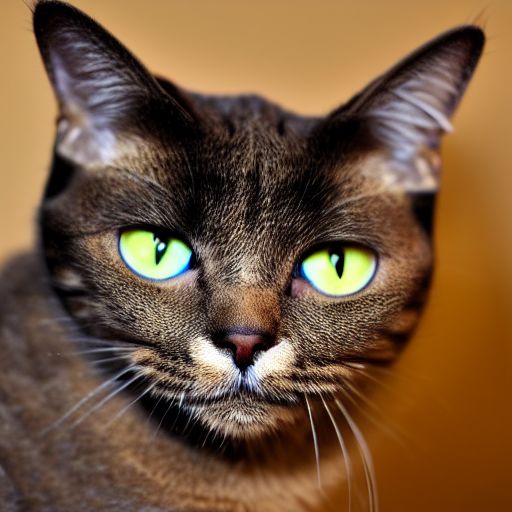

In [52]:
generate_with_embs(modified_output_embeddings)

In [53]:
prompt = 'skunk'
print('tokenizer(prompt):', tokenizer(prompt))
print('token_emb_layer([token_id]) shape:', token_emb_layer(torch.tensor([8797], device=torch_device)).shape)

tokenizer(prompt): {'input_ids': [49406, 42194, 49407], 'attention_mask': [1, 1, 1]}
token_emb_layer([token_id]) shape: torch.Size([1, 768])


/tmp/ipykernel_378/1994424325.py:22: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


0it [00:00, ?it/s]

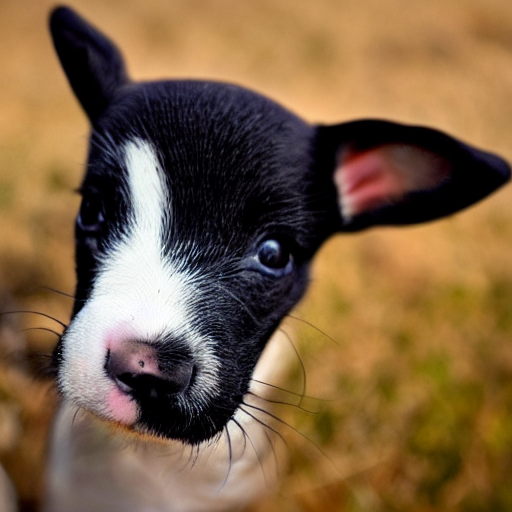

In [54]:
prompt = 'A picture of a puppy'

# Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Get token embeddings
token_embeddings = token_emb_layer(input_ids)

# The new embedding. Which is now a mixture of the token embeddings for 'puppy' and 'skunk'
puppy_token_embedding = token_emb_layer(torch.tensor(11650, device=torch_device))
skunk_token_embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
replacement_token_embedding = 0.5*puppy_token_embedding + 0.5*skunk_token_embedding

# Insert this into the token embeddings (
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

# Combine with pos embs
input_embeddings = token_embeddings + position_embeddings

#  Feed through to get final output embs
modified_output_embeddings = get_output_embeds(input_embeddings)

# Generate an image with these
generate_with_embs(modified_output_embeddings)